# SHERLOC Downlink Explorer

This program imports a SHERLOC RDR file, organizes the information, and plots their average spectra and their baseline-removed average spectra.  
  
By Eva Scheller & Jasper Miura, May 2021  
California Institute of Technology  
Division of Geological and Planetary Sciences

### How to download data? 

This is a script that explores the downlink output of a SHERLOC survey scans. 

So far you have to manually download data from datadrive and place it on the survey. 
Download the relevant file from the SHERLOC datadrive. 
Found here: 

Unprocessed EDR products are stored here: e.g. m20-sops-ods/ods/surface/sol/00083/ids/edr/shrlc/

Processed RDR products are stored here: e.g. m20-sops-ods/ods/surface/sol/00083/soas/rdr/srlc

You'll want to download the RDR products

Find additional information on data products here: data6 -> M2020 -> SHERLOC -> Literature -> InstrumentPapers -> SHERLOC_ug_2021_05_15.docx

SHERLOC context images are downloaded from Marsviewer.

### How to interpret filenames of RDR products? 

Our script will download data from the following set of information 

SS__XXXX = sol number <-- you'll have to manually enter this

SRLCXXXXX = sequence number <-- you'll have to manually enter this

W = wavelength calibration <-- automatic

C = cosmic ray correction <-- automatic

G = gain correction <-- automatic

N = laser photodiode normalization <-- automatic

## Set Variables  
Run this section before proceeding with script, to customize script.

- **data** : *str*  
 - Path to directory where data is located.  
 - (e.g. 'Y:\\jmiura\\SHERLOC\\0083\\RRS')  
- **save** : *str*  
 - Path to directory where results will be saved.  
 - (e.g. 'Y:\\jmiura\\SHERLOC\\0083')  
- **folder** : *str*  
 - Folder to create in save directory.  
 - (e.g. 'Processed')  
- **sequence** : *str*  
 - Identifier indicating the command sequence from which the data of  
  interest were acquired, which are the 36th to the 44th characters  
  in the file name.  
 - (e.g. 'SRLC10200')  
  
  ---
  
**TO BE ADDED**  
- Custom letters based on naming conventions so the amount of image pre-processing can be selected

#### Check your filepath situation

In [1]:
from os import getcwd
getcwd()

'/export/data6/M2020/SHERLOC/SHERLOC_DOWNLINK/Scripts'

#### Which ACI image do you want the grid from? 

In [2]:
ACI_image = 'SC3_0098_0675636936_460FDR_N0040136SRLC10203_0000LUJ01.IMG'

#### Local machine formatting - skip for server

In [3]:
data = 'Y:\\M2020\\SHERLOC\\SHERLOC_DOWNLINK\\Bi_la_sana\\0098\\RRS'
save = 'Y:\\M2020\\SHERLOC\\SHERLOC_DOWNLINK\\Bi_la_sana\\0098'
folder = 'Processed'
sequence = 'SRLC10200'
filename = 'Nataani'
laserWave = 248.6

#### Server formating - skip for local machine

In [4]:
data = '/export/data6/M2020/SHERLOC/SHERLOC_DOWNLINK/Bi_la_sana/0098/RRS'
save = '/export/data6/M2020/SHERLOC/SHERLOC_DOWNLINK/Bi_la_sana/0098'
folder = 'Processed'
sequence = 'SRLC10203'
filename = 'Nataani'
laserWave = 248.6

## Import Libraries  
Run this section before proceeding with script, to prepare all libraries.

In [5]:
from pathlib import Path
from os import path, getcwd, chdir, makedirs, listdir
import pandas as pd
import numpy as np
import copy
import string
import matplotlib.pyplot as plt

# Input and Organize Spectra
This section retrieves the data from files, and information from their labels. Basic calculations, including the mean and standard deviations of each region's spectra, as well as the Raman shift, are conducted.

### Functions and Classes

In [6]:
class Directory:
    """
    A class for storing directories.

    Parameters
    ----------
    dataDir : str
        Path to directory with hyperspectral image files.
    saveDir : str
        Path to directory where SMACC endmembers will be saved.
    saveFolder : str
        Folder in which to store SMACC endmembers within saveDir.

    Returns
    -------
    data : Path
        Path to directory with hyperspectral image files.
    code : Path
        Path to directory with script.
    save : Path
         Path to directory where SMACC endmembers will be saved.

    """

    def __init__(self, data, save, folder):

        self.data = Path(data)
        self.code = getcwd()

        if not path.exists(path.join(save, folder)):
            chdir(save)
            makedirs(folder)
        self.save = path.join(save, folder)


def get_filenames(dir, sequence):
    fileList = listdir(dir)
    processed = []
    for f in fileList:
        if (f[35:44] == sequence) and (f[44] == 'W') and (f[48] == 'C') and (f[49] == 'G') and (f[50] == 'N'):
            f = path.splitext(f)[0]
            if not f in processed:
                processed.append(f)
    return(processed)

def get_label(dir, fileName):
    info = get_label_info(dir, fileName)
    label = organize_label(info)
    return(label)


def get_label_info(dir, fileName):
    chdir(dir)
    file = open(fileName + '.LBL')
    info = file.read()
    info = info.split('\n')
    info = list(filter(None, info))
    info = [i.strip() for i in info]
    newInfo = []
    for i, s in enumerate(info):
        if ('=' not in s) and ('/*' not in s):
            newInfo[-1] += (' ' + s)
        else:
            newInfo.append(s)
    return(newInfo)


def organize_label(info):
    sectionInds = [info.index(s) for s in info if s.startswith('/*')]
    sectionInds.append(info.index(info[-1]))
    label = {}

    for i in range(0, sectionInds[0]):
        key, val = split_key_val(info, i)
        label[key] = val

    for si in range(len(sectionInds)-1):
        section = info[sectionInds[si]]
        section = section.replace('/* ', '')
        section = section.replace(' */', '')
        bulk = info[sectionInds[si]+1: sectionInds[si+1]]
        content = {}
        ci = 0

        while ci < len(bulk):
            key, val = split_key_val(bulk, ci)

            if key == 'GROUP':
                group = copy.deepcopy(val)
                content[group] = {}
                ci += 1
                key, val = split_key_val(bulk, ci)

                while key != 'END_GROUP':
                    content[group][key] = val
                    ci += 1
                    key, val = split_key_val(bulk, ci)

                ci += 1

            elif key == 'OBJECT':
                obj = 'OBJECT = ' + val
                typ = copy.deepcopy(val)
                content[obj] = {}
                ci += 1
                key, val = split_key_val(bulk, ci)

                while key != 'END_OBJECT' or val != typ:

                    if key == 'OBJECT':
                        subTyp = copy.deepcopy(val)
                        ci += 1
                        key, val = split_key_val(bulk, ci)
                        subObj = 'OBJECT = ' + val
                        content[obj][subObj] = {}
                        ci += 1
                        key, val = split_key_val(bulk, ci)

                        while key != 'END_OBJECT' or val != subTyp:
                            content[obj][subObj][key] = val
                            ci += 1
                            key, val = split_key_val(bulk, ci)

                    elif key == 'END_OBJECT':
                        ci += 1
                        if ci >= len(bulk):
                            break
                        key, val = split_key_val(bulk, ci)

                    else:
                        content[obj][key] = val
                        ci += 1
                        if ci >= len(bulk):
                            break
                        key, val = split_key_val(bulk, ci)

                ci += 1

            else:
                content[key] = val
                ci += 1

        label[section] = content
    return(label)


def split_key_val(bulk, ci):
    pair = bulk[ci]
    key, val = pair.split('=')
    key = key.strip()
    val = val.strip()
    return(key, val)


def get_spectra(dir, label, fileName):
    chdir(dir)
    size = get_data_size(label)
    csv = pd.read_csv(fileName + '.CSV', header=None,
                      names=range(size), low_memory=False)
    sections = get_sections(label, csv)
    spectra = {}
    for i in range(len(sections)-1):
        key = clean_key(csv[0][sections[i]])
        data = csv[sections[i]+2:sections[i+1]]
        spectra[key] = data.apply(pd.to_numeric).T
        indices = get_index_ints(csv.iloc[sections[0]+1])
        spectra[key] = spectra[key].reset_index(drop=True)

    return(spectra)


def get_data_size(label):
    pointers = get_pointers(label)
    [sciObj] = [value for key, value,
                in label.items() if 'science object' in key.lower()]
    dataObj = [value for key, value in sciObj.items()]
    fields = []
    for obj in dataObj:
        field = [obj[key] for key in obj.keys() if 'fields' in key.lower()]
        fields.append(field)
    [size] = max(fields)
    return(int(size))


def get_pointers(label):
    [pointers] = [label[key] for key in label if 'pointers' in key.lower()]
    pointers = [key.replace('^', '') for key in pointers]
    return(pointers)


def get_sections(label, csv):
    pointers = get_pointers(label)
    pointers = [s.translate(str.maketrans(
        '', '', string.punctuation)) for s in pointers]
    tableBreaks = [s.translate(str.maketrans(
        '', '', string.punctuation)) for s in csv[0]]
    tableBreaks = [s.replace(' ', '') for s in tableBreaks]
    sections = [tableBreaks.index(p) for p in pointers]
    sections.append(len(csv[0]))
    return(sections)


def clean_key(key):
    if 'WAVELENGTH' in key:
        newKey = 'WAVELENGTH'
    elif 'REGION_1' in key:
        newKey = 'REGION_1'
    elif 'REGION_2' in key:
        newKey = 'REGION_2'
    elif 'REGION_3' in key:
        newKey = 'REGION_3'
    else:
        newKey = key.replace(':', '')
        newKey = newKey.replace(' ', '_')
    return(newKey)


def get_index_ints(indices):
    indices = list(indices)
    numFilter = [filter(str.isdigit, i) for i in indices]
    nums = [int("".join(filt)) for filt in numFilter]
    return(nums)


def get_data_from_spectra(spectra, region):
    data = []
    for spc in spectra:
        dat = spc[region].iloc[50:-50, :]
        dat = dat.reset_index(drop=True)
        if region == 'WAVELENGTH':
            dat = dat[dat.columns[0]]
        data.append(dat)
    return(data)

## Retrieve Data  
Retrieves the spectral data, and divides into multiple dataframes for the channel wavelengths, the raman region from 250 to 282 nm (225 to 4760 cm-1), and two fluorescence regions up to 355 nm.

In [7]:
# Create a Directory object
dir = Directory(data, save, folder)
# Retrieve file names
files = get_filenames(dir.data, sequence)
print(files)

['SS__0098_0675636952_590RRS__0040136SRLC10203W108CGNJ01', 'SS__0098_0675637642_495RRS__0040136SRLC10203W308CGNJ01', 'SS__0098_0675636952_590RRS__0040136SRLC10203W108CGNJ02', 'SS__0098_0675637296_495RRS__0040136SRLC10203W208CGNJ02', 'SS__0098_0675637642_495RRS__0040136SRLC10203W308CGNJ02', 'SS__0098T0675636952_590RRS__0000000SRLC10203W108CGNJ01', 'SS__0098T0675637642_495RRS__0000000SRLC10203W308CGNJ01', 'SS__0098T0675637296_495RRS__0000000SRLC10203W208CGNJ01', 'SS__0098_0675637296_495RRS__0040136SRLC10203W208CGNJ01']


In [9]:
# Get spectral data for each file
spectra = []
for file in files:
    label = get_label(dir.data, file)
    spectra.append(get_spectra(dir.data, label, file))
    
# Extract wavelengths/raman spectra as DataFrames in list of files
waves = get_data_from_spectra(spectra, 'WAVELENGTH')
raman = get_data_from_spectra(spectra, 'REGION_1')

# Average Raman Spectra

This section takes the average spectrum for each Raman region and plots them alongside +/- standard deviation. Two views are shown, one zoomed in to the Raman shift region of interest.

### Functions and Classes

In [24]:
def get_average_spectrum(spc, waves):
    shift = ((1.0/laserWave - 1.0/waves) * 10 ** 7)
    mean = spc.mean(axis=1)
    std = spc.std(axis=1)
    return(shift, mean, std)


def get_lims(center, quartile, buff):
    max = center+quartile
    min = center-quartile

    buffer = (buff*(max-min))/2

    yupper = round((center+buffer)/10)*10
    ylower = round((center-buffer)/10)*10
    return((ylower, yupper))


def find_nearest(array, value):
    array = np.asarray(array)
    i = (np.abs(array - value)).argmin()
    return(i)


def plot_average_raman(rShift, rMean, rStd, color, title, label_txt):
    fig, ax = plt.subplots(2, figsize=[7, 7])
    ax[0].set_title(title)
    ax[0].set_xlabel('Raman Shift cm^-1')
    ax[0].set_ylabel('Intensity')
    ax[0].set_xlim(400, 4000)
    subMean = rMean[find_nearest(rShift, 400):find_nearest(rShift, 4000)]
    subStd = rStd[find_nearest(rShift, 400):find_nearest(rShift, 4000)]
    ax[0].set_ylim(get_lims(subMean.median(), subStd.median(), 1.5))
    ax[0].set_aspect(.4/ax[0].get_data_ratio())
    ax[0].plot(rShift, rMean,
               color='black', label=label_txt)
    ax[0].fill_between(rShift, rMean-rStd,
                       rMean+rStd, color=color, alpha=0.4, label='+/- 1 STD')
    fig.legend(bbox_to_anchor=(1.2, 0.89))

    ax[1].set_xlabel('Raman Shift cm^-1')
    ax[1].set_ylabel('Intensity')
    ax[1].set_xlim(400, 1300)
    subMean = rMean[find_nearest(rShift, 400):find_nearest(rShift, 1300)]
    ax[1].set_ylim(get_lims(subMean.median(), subMean.max(), 1))
    ax[1].set_aspect(.4/ax[1].get_data_ratio())
    ax[1].plot(rShift, rMean,
               color='black', label=label_txt)
    ax[1].fill_between(rShift, rMean-rStd,
                       rMean+rStd, color=color, alpha=0.4, label='+/- 1 STD')
    return(fig)

## Get Spectral Statistics
Get the mean and standard deviation for each raman spectrum.

In [25]:
ramanShift = []
ramanMean = []
ramanStd = []
ramanMedian = []
for i in range(len(raman)):
    shift, mean, std = get_average_spectrum(raman[i], waves[i])
    med = raman[i].median(axis=1)
    ramanShift.append(shift)
    ramanMean.append(mean)
    ramanStd.append(std)
    ramanMedian.append(med)

SomeStats = pd.DataFrame()
SomeStats['raman shift'] = ramanShift[2]
SomeStats['mean'] = ramanMean[2]
SomeStats['std'] = ramanStd[2]
SomeStats['median'] = ramanMedian[2]

SomeStats.to_csv(save + '/' + folder + '/' + filename + '_somestats.csv')
SomeStats

,raman shift,mean,std,median
0,210.055686,-14.75297,148.242034,-10.5690
1,220.620926,7.49215,85.165395,5.3190
2,231.020635,11.29218,70.712839,6.6740
3,241.414938,16.29458,64.309218,13.7805
4,251.963627,12.52786,70.521500,6.7685
...,...,...,...,...
2043,12080.824212,5.41874,104.894432,0.0205
2044,12083.913100,-12.88499,125.029183,-10.7590
2045,12087.080485,-1.30402,67.929739,-5.0705
2046,12090.247158,0.46312,77.759822,0.0000


## Average Raman Spectrum for Each Scan

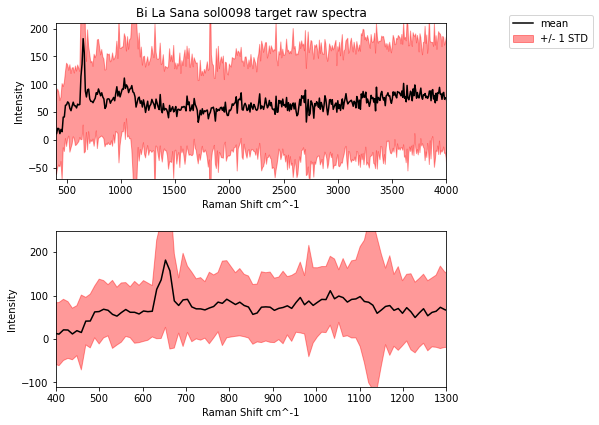

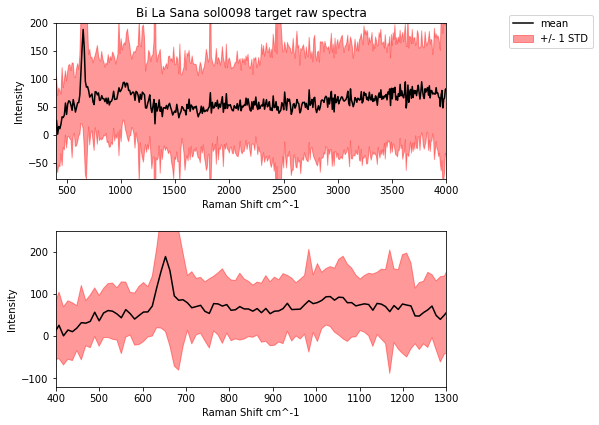

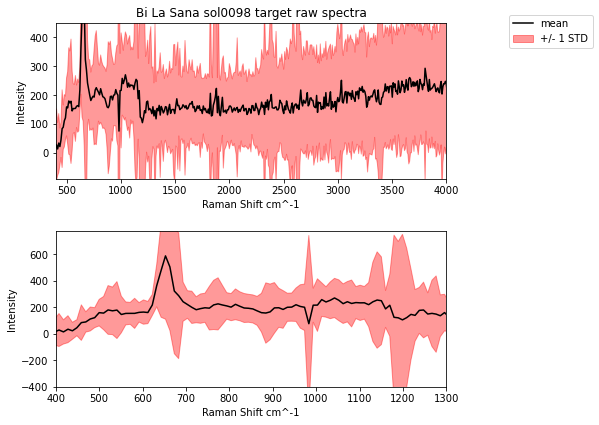

In [26]:
for i in range(len(ramanMean)):
    fig = plot_average_raman(
        ramanShift[i], ramanMean[i], ramanStd[i], 'red', 'Bi La Sana sol0098 target raw spectra', 'mean')

## Median Raman Spectrum for Each Scan

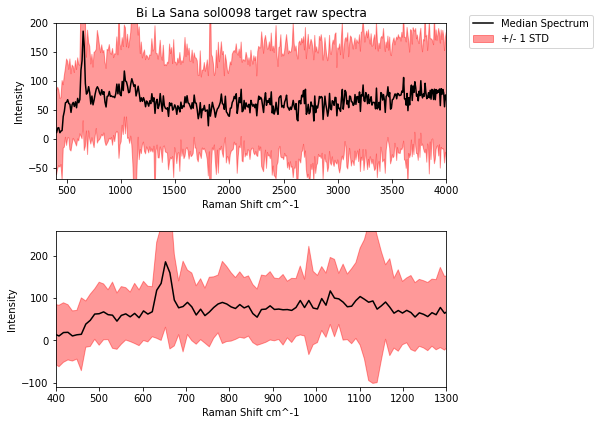

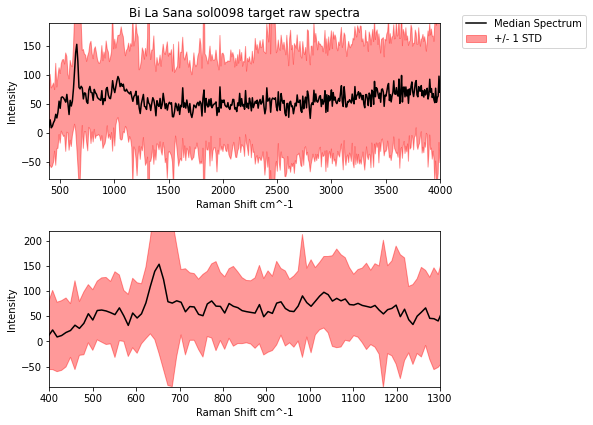

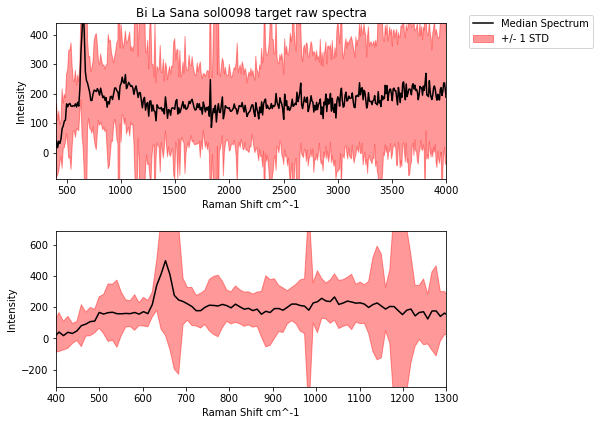

In [27]:
for i in range(len(ramanMedian)):
    fig = plot_average_raman(
        ramanShift[i], ramanMedian[i], ramanStd[i], 'red', 'Bi La Sana sol0098 target raw spectra', 'Median Spectrum')

# Baseline Removal: Investigate some options

This section uses the pybaselines library instead of the BaselineRemoval library: 

https://github.com/derb12/pybaselines

https://pypi.org/project/pybaselines/

You will need to install using pip: pip install --upgrade pybaselines[full]

Parameters: https://pybaselines.readthedocs.io/en/latest/api/pybaselines/index.html

## Which file do you want to process? Make your selection below

In [30]:
file_index = 2

### Functions and Classes

In [31]:
import pybaselines

def get_baselines(data):
    deg = 10
    keys = ['poly', 'modpoly', 'imodpoly', 'penalized_poly', 'loess',
        'asls', 'iasls', 'airpls', 'arpls', 'drpls', 'iarpls', 'aspls', 'psalsa',
        'mpls', 'mor', 'imor', 'mormol', 'amormol', 'rolling_ball',
        'noise_median', 'snip', 'swima',
        'collpls', 'opexra', 'addminmax']
    baselines = {k:[] for k in keys}
    for col in data.columns:
        # Polynomial Baselines
        baselines['poly'].append(pybaselines.polynomial.poly(data[col],poly_order=deg)[0])
        baselines['modpoly'].append(pybaselines.polynomial.modpoly(data[col],poly_order=deg)[0])
        baselines['imodpoly'].append(pybaselines.polynomial.imodpoly(data[col],poly_order=deg)[0])
        baselines['penalized_poly'].append(pybaselines.polynomial.penalized_poly(data[col],poly_order=deg)[0])
        baselines['loess'].append(pybaselines.polynomial.loess(data[col],poly_order=deg)[0])
        
        # Whittaker-Smoothing Baselines
        baselines['asls'].append(pybaselines.whittaker.asls(data[col])[0])
        baselines['iasls'].append(pybaselines.whittaker.iasls(data[col])[0])
        baselines['airpls'].append(pybaselines.whittaker.airpls(data[col])[0])
        baselines['arpls'].append(pybaselines.whittaker.arpls(data[col])[0])
        baselines['drpls'].append(pybaselines.whittaker.drpls(data[col])[0])
        baselines['iarpls'].append(pybaselines.whittaker.iarpls(data[col])[0])
        baselines['aspls'].append(pybaselines.whittaker.aspls(data[col])[0])
        baselines['psalsa'].append(pybaselines.whittaker.psalsa(data[col])[0])
        
        # Morphological Baselines
        baselines['mpls'].append(pybaselines.morphological.mpls(data[col])[0])
        baselines['mor'].append(pybaselines.morphological.mor(data[col])[0])
        baselines['imor'].append(pybaselines.morphological.imor(data[col])[0])
        baselines['mormol'].append(pybaselines.morphological.mormol(data[col])[0])
        baselines['amormol'].append(pybaselines.morphological.amormol(data[col])[0])
        baselines['rolling_ball'].append(pybaselines.morphological.rolling_ball(data[col])[0])
        
        # Window-Based Baselines
        baselines['noise_median'].append(pybaselines.window.noise_median(data[col], half_window=5)[0])
        baselines['snip'].append(pybaselines.window.snip(data[col], max_half_window=50)[0])
        baselines['swima'].append(pybaselines.window.swima(data[col])[0])
        
        
        # Optimizer Baselines
        #baselines['collpls'].append(pybaselines.optimizers.collab_pls(data[0])[0])
        #baselines['opexra'].append(pybaselines.optimizers.optimize_extended_range(data[0])[0])
        #baselines['addminmax'].append(pybaselines.optimizers.adaptive_minmax(data[0])[0])

    for key in keys:
        baselines[key] = np.mean(baselines[key], axis=0).T
    return(baselines)

def plot_baselines(ramanShift, ramanMean, baselines, xlim):
    # Initialize plots
    fig, ax = plt.subplots(5, figsize=(10, 20))
    ax[0].set_title('POLYNOMIAL BASELINES', x=0.5, y=0.9)
    ax[1].set_title('WHITTAKER-SMOOTHING BASELINES', x=0.5, y=0.9)
    ax[2].set_title('MORPHOLOGICAL BASELINES', x=0.5, y=0.9)
    ax[3].set_title('WINDOW-BASED BASELINES', x=0.5, y=0.9)
    ax[4].set_title('SELECT BASELINE-REMOVED SPECTRA', x=0.5, y=0.9)

    # Polynomial Baselines
    ax[0].plot(ramanShift, ramanMean, color='black', label='Original Average Spectrum', lw=0.5)
    ax[0].plot(ramanShift, baselines['poly'], label='poly')
    ax[0].plot(ramanShift, baselines['modpoly'], label='modpoly')
    ax[0].plot(ramanShift, baselines['imodpoly'], label='imodpoly')
    ax[0].plot(ramanShift, baselines['penalized_poly'], label='penalized_poly')
    ax[0].plot(ramanShift, baselines['loess'], label='loess')

    # Whittaker-Smoothing Baselines
    ax[1].plot(ramanShift, ramanMean, color='black', label='Original Average Spectrum', lw=0.5)
    ax[1].plot(ramanShift, baselines['asls'], label='asls')
    ax[1].plot(ramanShift, baselines['iasls'], label='iasls')
    ax[1].plot(ramanShift, baselines['airpls'], label='airpls')
    ax[1].plot(ramanShift, baselines['arpls'], label='arpls')
    ax[1].plot(ramanShift, baselines['drpls'], label='drpls')
    ax[1].plot(ramanShift, baselines['iarpls'], label='iarpls')
    ax[1].plot(ramanShift, baselines['aspls'], label='aspls')
    ax[1].plot(ramanShift, baselines['psalsa'], label='psalsa')

    # Morphological Baselines
    ax[2].plot(ramanShift, ramanMean, color='black', label='Original Average Spectrum', lw=0.5)
    ax[2].plot(ramanShift, baselines['mpls'], label='mpls')
    ax[2].plot(ramanShift, baselines['mor'], label='mor')
    ax[2].plot(ramanShift, baselines['imor'], label='imor')
    ax[2].plot(ramanShift, baselines['mormol'], label='mormol')
    ax[2].plot(ramanShift, baselines['amormol'], label='amormol')
    ax[2].plot(ramanShift, baselines['rolling_ball'], label='rolling_ball')

    # Window-Based Baselines
    ax[3].plot(ramanShift, ramanMean, color='black', label='Original Average Spectrum', lw=0.5)
    ax[3].plot(ramanShift, baselines['noise_median'], label='noise_median')
    ax[3].plot(ramanShift, baselines['snip'], label='snip')
    ax[3].plot(ramanShift, baselines['swima'], label='swima')

    # Select Baseline-Removed Spectra
    ax[4].plot(ramanShift, ramanMean, color='black', label='Original Average Spectrum', lw=0.5)
    ax[4].plot(ramanShift, ramanMean-baselines['noise_median'], label='noise_median', lw=0.5)
    ax[4].plot(ramanShift, ramanMean-baselines['aspls'], label='aspls', lw=0.5)
    ax[4].plot(ramanShift, ramanMean-baselines['drpls'], label='drpls', lw=0.5)
    ax[4].plot(ramanShift, ramanMean-baselines['arpls'], label='arpls', lw=0.5)

    # Modify plots
    for a in ax:
        a.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        a.set_xlim(xlim)
    fig.subplots_adjust(wspace=0, hspace=0)
    return(fig)

## Remove Baseline, Then Average

/home/eschelle/anaconda3/envs/SHERLOC/lib/python3.9/site-packages/pybaselines/whittaker.py:311: RuntimeWarning: invalid value encountered in true_divide
  weight_array[neg_mask] = np.exp(i * neg_residual / residual_l1_norm)
/home/eschelle/anaconda3/envs/SHERLOC/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eschelle/anaconda3/envs/SHERLOC/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


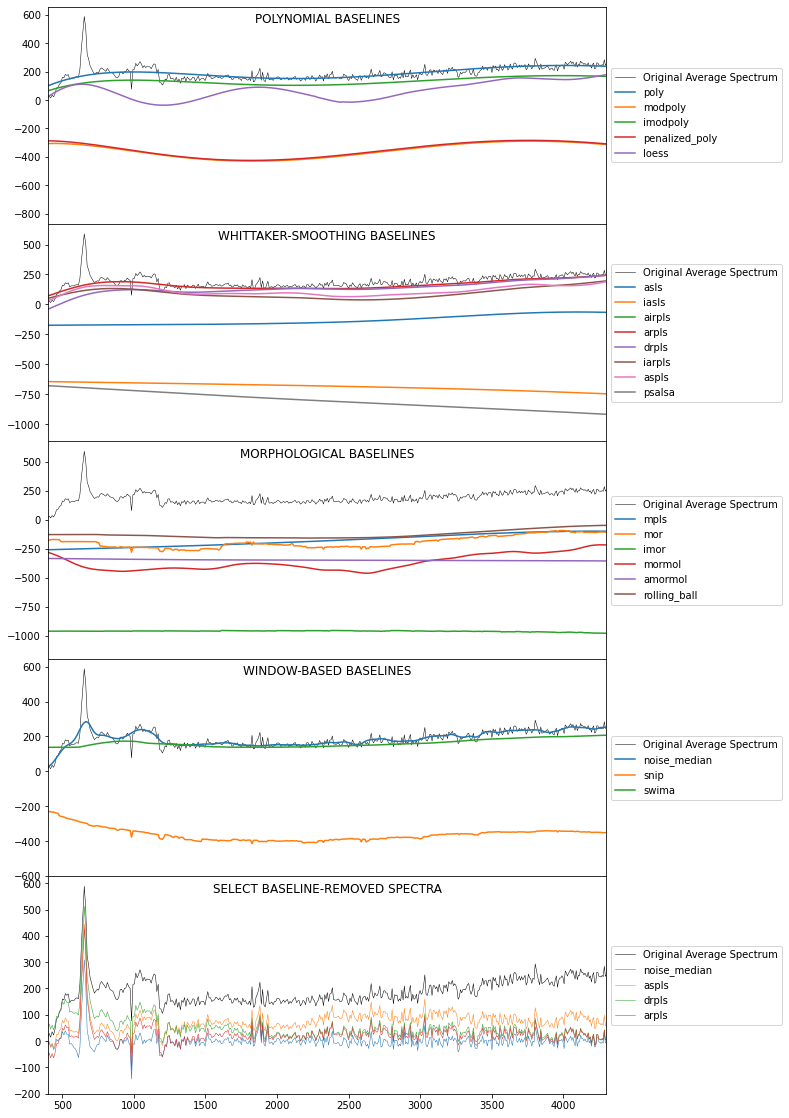

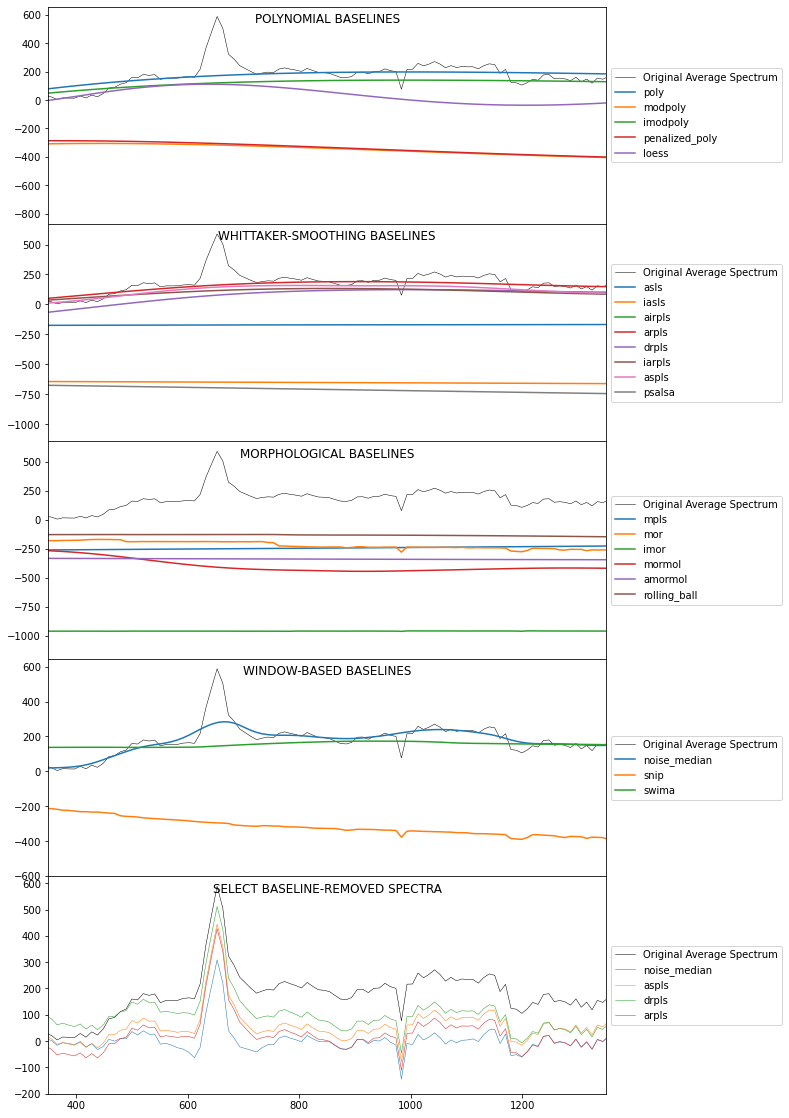

In [94]:
baselines = get_baselines(raman[file_index])
fullSpectra = plot_baselines(ramanShift[file_index], ramanMean[file_index], baselines, (400, 4300))
fullSpectra = plot_baselines(ramanShift[file_index], ramanMean[file_index], baselines, (350, 1350))

## Average, then Remove Baseline

/home/eschelle/anaconda3/envs/SHERLOC/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eschelle/anaconda3/envs/SHERLOC/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


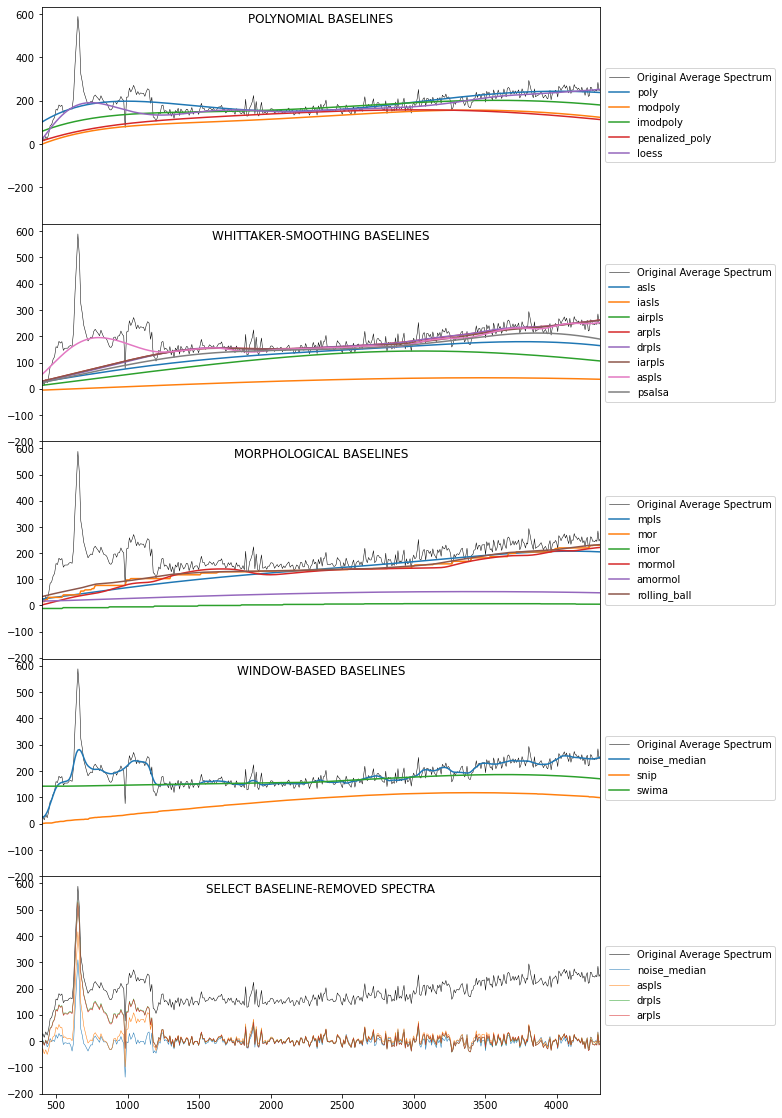

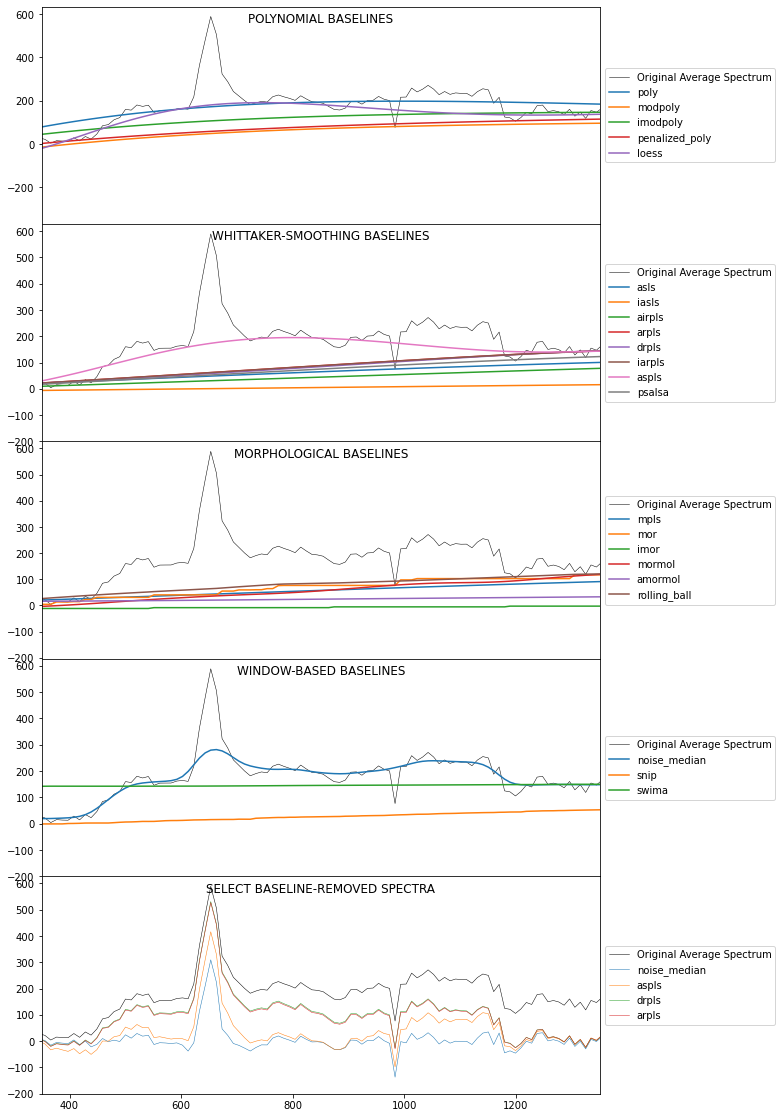

In [95]:
baselines = get_baselines(pd.DataFrame(ramanMean[file_index]))
fullSpectra = plot_baselines(ramanShift[file_index], ramanMean[file_index], baselines, (400, 4300))
fullSpectra = plot_baselines(ramanShift[file_index], ramanMean[file_index], baselines, (350, 1350))

# Re-iterate on your best baseline removal result

### Set your baseline parameters

Try some different baseline models until you're happy - window swima seems to work well with the SHERLOC data. 

Polynomial: deg, order of polynomial (poly_order=2)

Whittaker: lam, smoothing parameter (lam = 1e6)

Morphology: lam, smoothing parameter (lam = 1e6), half_window

Window: swima(data, max_half_window, decreasing=False, smooth_half_window=None, filter_order=2, **pad_kwargs)
    
max_half_window,
        max_half_window : int or Sequence(int, int)
        The maximum number of iterations. Should be set such that
        `max_half_window`=(w-1)/2, where w is the index-based width of a
        feature or peak. `max_half_window` can also be a sequence of two
        integers for asymmetric peaks, with the first item corresponding to
        the `max_half_window` of the peak's left edge, and the second item
        for the peak's right edge [3]_.

smooth_half_window : int, optional
        The half window to use for smoothing the data. If `smooth_half_window`
        is greater than 0, will perform a moving average smooth on the data for
        each window, which gives better results for noisy data [3]_. Default is
        None, which will not perform any smoothing.

### Custom parameters - change as wanted

In [32]:
mhw = 40 #max half window
shw = 20 #smooth half window

#default
#mhw = 20 #max half window
#shw = 10 #smooth half window

(400.0, 4300.0)

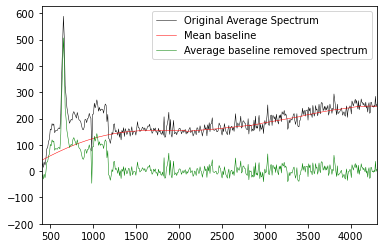

In [33]:
spectral_grid = pd.DataFrame(ramanMean[file_index])

best_baselines = []
for col in spectral_grid.columns:
    best_baseline = pybaselines.window.swima(spectral_grid[col], max_half_window=mhw,smooth_half_window=shw)[0]
    best_baselines.append(best_baseline)
mean_baseline = best_baselines[0]

plt.figure()
plt.plot(ramanShift[file_index], ramanMean[file_index], color='black', label='Original Average Spectrum', lw=0.5)
plt.plot(ramanShift[file_index], mean_baseline, color='red', label='Mean baseline', lw=0.5)
plt.plot(ramanShift[file_index], ramanMean[file_index]-mean_baseline, color='green',label='Average baseline removed spectrum', lw=0.5)
plt.legend()
plt.xlim(400, 4300)


In [34]:
all_baselines = []
all_processed_spectra = []
for col in raman[file_index].columns:
    baseline = pybaselines.window.swima(raman[2][col], max_half_window=mhw,smooth_half_window=shw)[0]
    all_processed_spectra.append(raman[2][col] - baseline)
    all_baselines.append(baseline)

In [35]:
all_baselines = pd.DataFrame(all_baselines)
all_processed_spectra = pd.DataFrame(all_processed_spectra)
all_processed_spectra

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
5,-638.396552,69.282965,67.001805,100.249885,90.507965,149.170895,85.346871,-112.944413,9.460208,44.246351,...,15.832894,-49.427751,47.873822,-2.232675,-27.189358,290.322350,-224.628191,-92.022597,-109.353844,-11.626560
6,-45.670732,-37.825797,37.595662,130.537595,-96.905039,101.167720,16.408840,94.355291,62.183046,142.663081,...,-20.028423,-135.207958,125.065166,-57.693042,44.891425,-52.763422,59.834425,-87.879026,-7.818766,57.224214
7,-53.135028,-8.351227,-41.298872,-36.449558,82.396751,-51.616989,-78.900380,0.283382,10.988874,-56.817927,...,-44.351574,-87.067700,-57.090274,8.325291,-11.663827,176.919489,-42.617573,56.415913,65.571023,42.880743
8,81.010015,130.060538,108.726698,105.055674,186.968342,130.584368,84.322098,168.928668,132.855275,300.604541,...,54.623465,184.175002,120.020083,123.775157,89.789440,189.118962,109.839560,133.691304,99.682466,121.012812
9,16.773602,116.048924,76.530558,57.434737,49.071703,-33.758149,37.511398,-74.007384,-58.405874,-65.137895,...,93.066799,133.074242,92.402915,64.318176,-4.039652,48.609543,65.979202,40.510065,83.105829,34.973233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-174.590964,-27.702822,86.556312,-71.967847,-28.469853,35.216671,-19.521390,116.360771,-71.308151,-10.749903,...,39.888153,47.552270,102.068972,24.687922,16.140856,90.082744,-50.402981,-89.103251,-15.048208,-26.177161
101,-54.110963,-3.323503,-88.727547,36.975823,-20.802764,5.116083,-78.676148,-114.597751,72.987671,65.697931,...,-47.919456,30.806886,-138.202291,20.998375,14.842264,141.113336,-121.274843,-124.275074,-94.056539,21.778995
102,-155.035808,-12.379114,-28.516125,-3.352201,-27.958176,138.705255,-19.909533,-27.686118,23.782264,-32.883080,...,-7.506962,-7.038167,29.413157,-8.851340,-38.759950,76.033074,-124.695090,103.899337,60.147004,2.565897
103,1.496692,27.469692,100.652265,-69.495638,55.457356,82.186169,-51.845713,-10.318497,6.646345,2.098557,...,-25.354260,16.457046,-2.770634,105.625494,-46.778784,-46.589688,22.958542,-29.570695,-87.649336,31.835426


### Some plotting to investigate how well your baseline algorithm is doing

Text(0.5, 1.0, 'Bi La Sana sol0098 target, baseline removed (custom algorithm)')

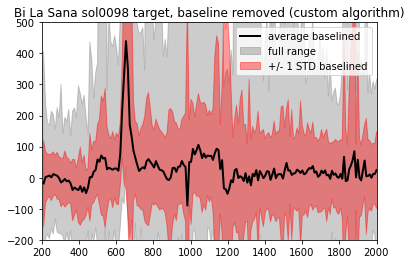

In [37]:
mean_spectrum = all_processed_spectra.mean(axis=0)
std_spectrum = all_processed_spectra.std(axis=0)
min_spectrum = all_processed_spectra.min(axis=0)
max_spectrum = all_processed_spectra.max(axis=0)

plt.figure()
plt.fill_between(ramanShift[file_index], min_spectrum,
                       max_spectrum, color='grey', alpha=0.4, label='full range')
plt.fill_between(ramanShift[file_index], mean_spectrum-std_spectrum,
                       mean_spectrum+std_spectrum, color='red', alpha=0.4, label='+/- 1 STD baselined')
plt.plot(ramanShift[file_index],mean_spectrum,color='black',linewidth=2,label='average baselined')
plt.legend()
plt.xlim(200,2000)
plt.ylim(-200,500)
plt.title('Bi La Sana sol0098 target, baseline removed (custom algorithm)')

Text(0.5, 1.0, 'Bi La Sana sol0098 target, baseline removed (custom algorithm)')

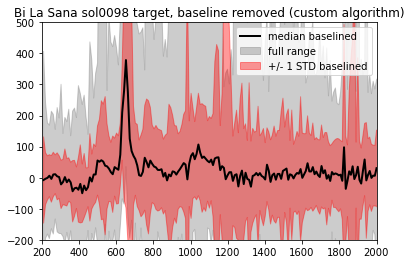

In [38]:
med_spectrum = all_processed_spectra.median(axis=0)
plt.figure()
plt.fill_between(ramanShift[file_index], min_spectrum,
                       max_spectrum, color='grey', alpha=0.4, label='full range')
plt.fill_between(ramanShift[file_index], med_spectrum-std_spectrum,
                       med_spectrum+std_spectrum, color='red', alpha=0.4, label='+/- 1 STD baselined')
plt.plot(ramanShift[file_index],med_spectrum,color='black',linewidth=2,label='median baselined')
plt.legend()
plt.xlim(200,2000)
plt.ylim(-200,500)
plt.title('Bi La Sana sol0098 target, baseline removed (custom algorithm)')

In [39]:
SomeStats = pd.DataFrame()
SomeStats['raman shift'] = ramanShift[2]
SomeStats['mean'] = mean_spectrum
SomeStats['std'] = std_spectrum
SomeStats['median'] = med_spectrum

SomeStats.to_csv(save + '/' + folder + '/' + 'filename' + '_baselined_somestats.csv')
SomeStats

,raman shift,mean,std,median
0,210.055686,-18.498981,138.770112,-7.403373
1,220.620926,1.916345,83.590812,-3.412033
2,231.020635,3.991732,71.153273,-0.582423
3,241.414938,7.085512,67.612610,6.349516
4,251.963627,1.067277,75.005461,-3.904029
...,...,...,...,...
2043,12080.824212,20.378698,134.783627,10.721363
2044,12083.913100,2.039815,151.285749,-0.185512
2045,12087.080485,13.443586,124.846111,3.322126
2046,12090.247158,14.408743,117.557756,8.647676


#### Change your index i to investigate individual spectra

In [158]:
i = 100

(-200.0, 600.0)

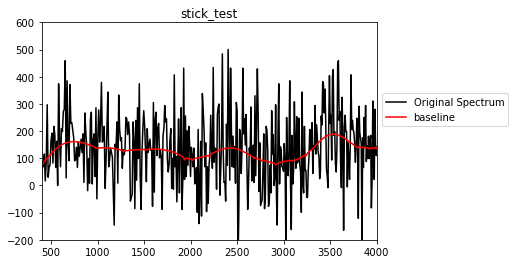

In [159]:
plt.figure()
plt.title('stick_test')
plt.plot(ramanShift[file_index],raman[file_index][i],color='black',label='Original Spectrum')
plt.plot(ramanShift[file_index],all_baselines.T[i-5],color='red',label='baseline')
#plt.plot(ramanShift[2],all_processed_spectra.T[5],color='green',label='baseline removed')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlim(400, 4000)
plt.ylim(-200,600)

#### Plot all the spectra offset from each other in 10 different plots

In [160]:
def plot_ten_spectra(ramanshift,all_spectra,range_start,range_end,xlims,ylims,n_step):
    
    plt.figure(1)
    plt.title('Display 10 spectra stacked')
    plt.xlabel('ramanshift cm^-1')
    plt.ylabel('intensity (offset for clarity)')
    plt.xlim(xlims)
    n = 0
    for i in range(range_start,range_end):
        plt.plot(ramanshift,all_spectra[i] + n)
        n+=n_step
    plt.ylim(ylims)
    plt.show()
    
    return
    

In [161]:
range_start_list = np.arange(5,105,10)
range_end_list = np.arange(15,110,10)

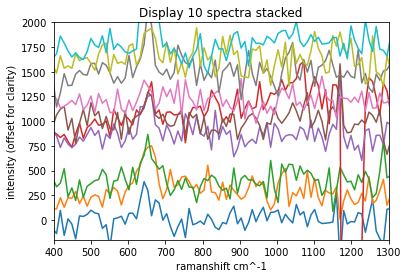

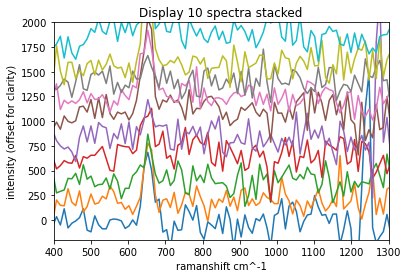

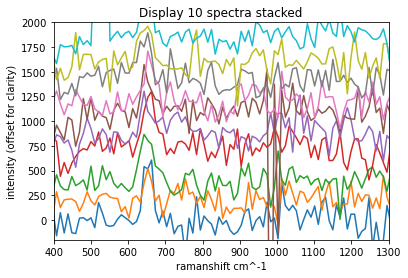

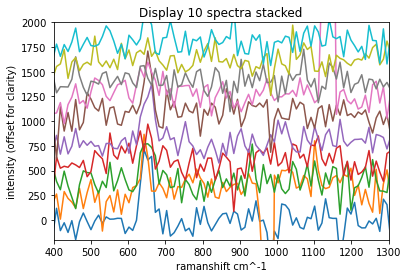

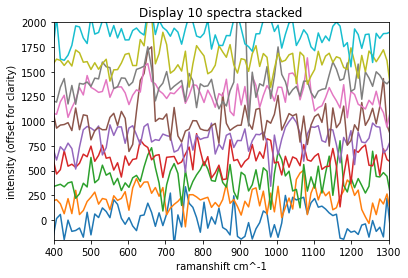

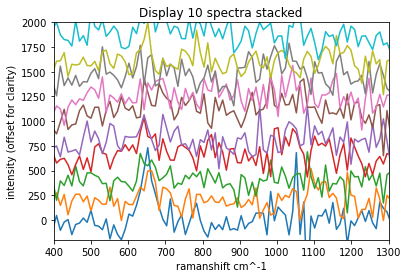

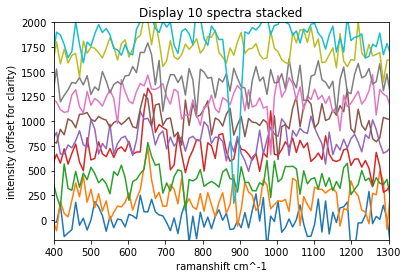

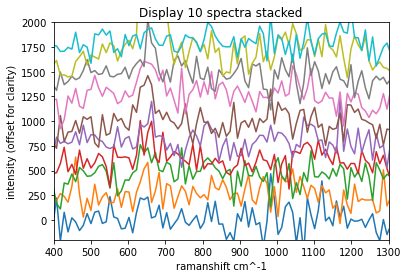

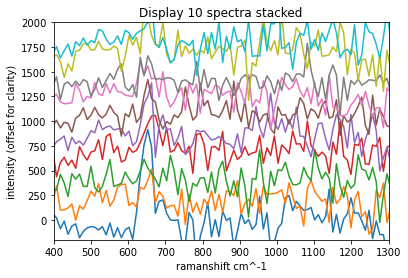

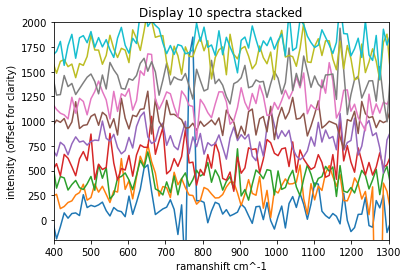

In [162]:
ramanshift = ramanShift[file_index]
all_spectra = all_processed_spectra.T
n_step = 200
xlims = (400, 1300)
ylims = (-200,2000)

for i in range(len(range_start_list)):
    range_start = range_start_list[i]
    range_end = range_end_list[i]
    plot_ten_spectra(ramanshift,all_spectra,range_start,range_end,xlims,ylims,n_step)

# Get grid coordinates and save data

In [163]:
def get_coord_files(dir, filenames):
    filenames_reduced = []
    for f in filenames:
        filenames_reduced.append(f[0:23])

    fileList = listdir(dir)
    processed = []
    
    for i in fileList:
        if i[0:23] in filenames_reduced:
            i = path.splitext(i)[0]
            if not i in processed:
                processed.append(i)
    
    return processed

## Retrieve data

In [168]:
coord_files = coord_files[0:3]

In [175]:
data_coord = data[:len(data)-3] + 'RLS'
dir = Directory(data_coord, save, folder)
coord_files = get_coord_files(dir.data, files)
coord_files

['SS__0098_0675636952_590RLS__0040136SRLC10203_108___J01',
 'SS__0098_0675637642_495RLS__0040136SRLC10203_308___J01',
 'SS__0098_0675637296_495RLS__0040136SRLC10203_208___J01',
 'SS__0098_0675637642_495RLS__0040136SRLC10203_308___J03',
 'SS__0098_0675636952_590RLS__0040136SRLC10203_108___J02',
 'SS__0098_0675637296_495RLS__0040136SRLC10203_208___J02',
 'SS__0098_0675637642_495RLS__0040136SRLC10203_308___J02']

In [177]:
coord_files = coord_files[4:]
coord_files

['SS__0098_0675636952_590RLS__0040136SRLC10203_108___J02',
 'SS__0098_0675637296_495RLS__0040136SRLC10203_208___J02',
 'SS__0098_0675637642_495RLS__0040136SRLC10203_308___J02']

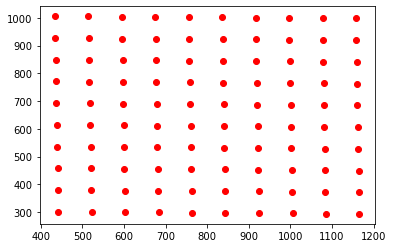

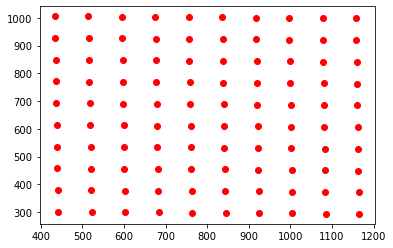

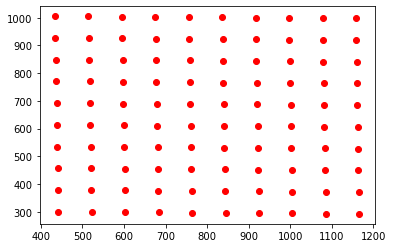

In [180]:
grids = []
for f in coord_files:
    df = pd.read_csv(data_coord + '/' + f + '.CSV',skiprows=1)
    df = df[df.image_name == ACI_image]
    grid = df[:100]
    grids.append(grid)

x = grids[0]['samp']
y = grids[0]['line']

plt.figure()
plt.plot(x,y,'o',color='red')

x = grids[1]['samp']
y = grids[1]['line']

plt.figure()
plt.plot(x,y,'o',color='red')

x = grids[2]['samp']
y = grids[2]['line']

plt.figure()
plt.plot(x,y,'o',color='red')

## Get grid coordinates and ACI image

### Which spectrum do you want to export?

In [181]:
print(coord_files)

['SS__0098_0675636952_590RLS__0040136SRLC10203_108___J02', 'SS__0098_0675637296_495RLS__0040136SRLC10203_208___J02', 'SS__0098_0675637642_495RLS__0040136SRLC10203_308___J02']


#### set index for coordinate grid

In [182]:
index = file_index # set index for the grid file that you care about
x = np.array(grids[index]['samp'])
y = np.array(grids[index]['line'])

#### set which baseline removed spectra you want to save

You should have it stored in the all_processed_spectra dataframe

In [183]:
baselined_grid = all_processed_spectra #change the dataframe here after inspection of results
baselined_grid['x'] = x
baselined_grid['y'] = y
baselined_grid = baselined_grid.reset_index(drop=True)
baselined_grid

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,x,y
0,-638.396552,69.282965,67.001805,100.249885,90.507965,149.170895,85.346871,-112.944413,9.460208,44.246351,...,47.873822,-2.232675,-27.189358,290.322350,-224.628191,-92.022597,-109.353844,-11.626560,442.141,301.153
1,-45.670732,-37.825797,37.595662,130.537595,-96.905039,101.167720,16.408840,94.355291,62.183046,142.663081,...,125.065166,-57.693042,44.891425,-52.763422,59.834425,-87.879026,-7.818766,57.224214,522.509,300.153
2,-53.135028,-8.351227,-41.298872,-36.449558,82.396751,-51.616989,-78.900380,0.283382,10.988874,-56.817927,...,-57.090274,8.325291,-11.663827,176.919489,-42.617573,56.415913,65.571023,42.880743,602.922,299.408
3,81.010015,130.060538,108.726698,105.055674,186.968342,130.584368,84.322098,168.928668,132.855275,300.604541,...,120.020083,123.775157,89.789440,189.118962,109.839560,133.691304,99.682466,121.012812,683.225,298.228
4,16.773602,116.048924,76.530558,57.434737,49.071703,-33.758149,37.511398,-74.007384,-58.405874,-65.137895,...,92.402915,64.318176,-4.039652,48.609543,65.979202,40.510065,83.105829,34.973233,763.661,297.677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-174.590964,-27.702822,86.556312,-71.967847,-28.469853,35.216671,-19.521390,116.360771,-71.308151,-10.749903,...,102.068972,24.687922,16.140856,90.082744,-50.402981,-89.103251,-15.048208,-26.177161,755.625,1002.144
96,-54.110963,-3.323503,-88.727547,36.975823,-20.802764,5.116083,-78.676148,-114.597751,72.987671,65.697931,...,-138.202291,20.998375,14.842264,141.113336,-121.274843,-124.275074,-94.056539,21.778995,675.125,1002.651
97,-155.035808,-12.379114,-28.516125,-3.352201,-27.958176,138.705255,-19.909533,-27.686118,23.782264,-32.883080,...,29.413157,-8.851340,-38.759950,76.033074,-124.695090,103.899337,60.147004,2.565897,594.907,1003.799
98,1.496692,27.469692,100.652265,-69.495638,55.457356,82.186169,-51.845713,-10.318497,6.646345,2.098557,...,-2.770634,105.625494,-46.778784,-46.589688,22.958542,-29.570695,-87.649336,31.835426,514.305,1004.817


In [184]:
baselined_grid.to_csv(save + '/' + folder + '/' + coord_files[index] + '_baselined_grid_final.csv')

In [185]:
all_baselines

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,-61.603448,-56.782965,-52.001805,-47.749885,-45.507965,-39.170895,-32.846871,-27.055587,-21.960208,-16.746351,...,-5.832894,-5.572249,-5.373822,-5.267325,-5.310642,-5.322350,-5.371809,-5.477403,-5.646156,-5.873440
1,-4.389268,-2.222203,-0.050662,2.122405,4.294039,6.461280,8.621160,10.770709,12.906954,15.026919,...,-7.504577,-7.464042,-7.424166,-7.384958,-7.346425,-7.308578,-7.271425,-7.234974,-7.199234,-7.164214
2,28.052028,28.418227,28.756872,28.924558,27.970249,29.041989,28.733380,29.816618,31.653126,34.242927,...,6.726574,6.800700,6.923274,6.724709,6.646827,6.189511,4.992573,6.293087,7.170977,7.286257
3,-113.712015,-114.967538,-116.273698,-117.633674,-119.049342,-120.522368,-122.055098,-123.649668,-125.308275,-127.033541,...,-147.698465,-146.442002,-145.175083,-143.899157,-142.615440,-141.323962,-140.025560,-138.722304,-137.415466,-136.105812
4,46.239398,47.784076,49.494442,50.947263,51.748297,53.922149,55.747602,58.884384,60.926874,62.616895,...,-12.410799,-12.090242,-11.746915,-11.387176,-11.083348,-10.801543,-10.528202,-10.264065,-10.010829,-9.768233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,26.117964,27.702822,28.922688,30.724847,33.968853,36.270329,38.768390,40.361229,43.813151,46.493903,...,-1.395153,-0.810270,-0.336972,0.058078,0.356144,0.651256,0.911981,1.119251,1.300208,1.431161
96,-9.309037,-7.706497,-7.781453,-3.886823,-1.256236,3.155917,6.983148,9.816751,15.249329,22.539069,...,14.830456,16.069114,16.876291,17.605625,18.246736,18.815664,19.250843,19.494074,19.606539,19.582005
97,-13.755192,-9.757886,-7.455875,-4.948799,-2.479824,-0.352255,3.307533,8.317118,12.189736,16.281080,...,-28.465038,-28.933833,-29.413157,-29.887660,-30.417050,-31.760074,-33.027910,-31.955337,-32.476004,-33.003897
98,-9.819692,-8.048692,-6.321265,-5.414362,-5.517356,-4.501169,-3.643287,-0.779503,4.451655,6.224443,...,-27.360740,-27.555046,-27.748366,-27.940494,-28.131216,-28.320312,-28.507542,-28.693305,-28.877664,-29.061426


In [186]:
all_baselines.to_csv(save + '/' + folder + '/' + coord_files[index] + '_baselines_grid.csv')

In [187]:
raw_spectra = raman[file_index].T
raw_spectra = raw_spectra.reset_index(drop=True)
raw_spectra

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,-700.000,12.500,15.000,52.500,45.000,110.000,52.500,-140.000,-12.500,27.500,...,10.000,-55.000,42.500,-7.500,-32.500,285.000,-230.000,-97.500,-115.000,-17.500
1,-50.060,-40.048,37.545,132.660,-92.611,107.629,25.030,105.126,75.090,157.690,...,-27.533,-142.672,117.641,-65.078,37.545,-60.072,52.563,-95.114,-15.018,50.060
2,-25.083,20.067,-12.542,-7.525,110.367,-22.575,-50.167,30.100,42.642,-22.575,...,-37.625,-80.267,-50.167,15.050,-5.017,183.109,-37.625,62.709,72.742,50.167
3,-32.702,15.093,-7.547,-12.578,67.919,10.062,-37.733,45.279,7.547,173.571,...,-93.075,37.733,-25.155,-20.124,-52.826,47.795,-30.186,-5.031,-37.733,-15.093
4,63.013,163.833,126.025,108.382,100.820,20.164,93.259,-15.123,2.521,-2.521,...,80.656,120.984,80.656,52.931,-15.123,37.808,55.451,30.246,73.095,25.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-148.473,0.000,115.479,-41.243,5.499,71.487,19.247,156.722,-27.495,35.744,...,38.493,46.742,101.732,24.746,16.497,90.734,-49.491,-87.984,-13.748,-24.746
96,-63.420,-11.030,-96.509,33.089,-22.059,8.272,-71.693,-104.781,88.237,88.237,...,-33.089,46.876,-121.326,38.604,33.089,159.929,-102.024,-104.781,-74.450,41.361
97,-168.791,-22.137,-35.972,-8.301,-30.438,138.353,-16.602,-19.369,35.972,-16.602,...,-35.972,-35.972,0.000,-38.739,-69.177,44.273,-157.723,71.944,27.671,-30.438
98,-8.323,19.421,94.331,-74.910,49.940,77.685,-55.489,-11.098,11.098,8.323,...,-52.715,-11.098,-30.519,77.685,-74.910,-74.910,-5.549,-58.264,-116.527,2.774


In [188]:
raw_spectra.to_csv(save + '/' + folder + '/' + coord_files[index] + '_raw_grid.csv')

In [189]:
waves[index]

0       249.905
1       249.971
2       250.036
3       250.101
4       250.167
         ...   
2043    355.310
2044    355.349
2045    355.389
2046    355.429
2047    355.468
Name: 2, Length: 2048, dtype: float64

In [190]:
waves[index].to_csv(save + '/' + folder + '/' + coord_files[index] + '_waves.csv')

# Run grid explorer dash app

To run the grid explorer, you must first update the file paths to the save folder in which you have saved your above reduced files. 

Run the below line and copy the ip address into your browser. 
It may get blocked by certain browsers, google chrome should work but it depends on security settings.

The ! in jupyter notebook is just a way to run a command in the terminal from where jupyter notebook is running. 
If you click kernel -> interrupt; it will be the same as CTRL+C in terminal and will terminate the dash app. 

Though you may want to just run this line directly from terminal since it will print all the actions that you did within the app. 

In [60]:
!python 'SHERLOCGrid_DashBoard.py'

Dash is running on http://clark.gps.caltech.edu:8151/

 * Serving Flask app "SHERLOCGrid_DashBoard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://clark.gps.caltech.edu:8151/ (Press CTRL+C to quit)
^C
